# Miniprojeto Clustering

### Grupo:
#### - Caio Rocha Calado
#### - Gabriel Ayres Barbosa
#### - Emanoel Thyago Cordeiro dos Santos
#### - Mateus Araújo Neves
#### - Rafael Ramos Batista Corcino

# Instalando as dependências

In [1366]:
!pip install kmodes

# Importando as Bibliotecas

In [1367]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import pairwise_distances
import warnings

# Análise Inicial dos Dados

In [1368]:
# Carregando os arquivos
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
target_test = pd.read_csv('/content/gender_submission.csv')

In [1369]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1370]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [1371]:
print(train_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [1372]:
print(train_df.nunique())

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


In [1373]:
print(train_df.head())

   PassengerId  Survived  Pclass                                                 Name     Sex  \
0            1         0       3                              Braund, Mr. Owen Harris    male   
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)  female   
2            3         1       3                               Heikkinen, Miss. Laina  female   
3            4         1       1         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female   
4            5         0       3                             Allen, Mr. William Henry    male   

    Age  SibSp  Parch            Ticket     Fare Cabin Embarked  
0  22.0      1      0         A/5 21171   7.2500   NaN        S  
1  38.0      1      0          PC 17599  71.2833   C85        C  
2  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S  
3  35.0      1      0            113803  53.1000  C123        S  
4  35.0      0      0            373450   8.0500   NaN        S  


# Pré-processamento dos Dados

In [1374]:
# Removendo colunas irrelevantes
train_df = train_df.drop(['PassengerId', 'Name', 'Cabin', 'Ticket', 'Survived'], axis=1)
train_df = train_df.dropna(subset=['Sex', 'Embarked'])

# Mapeando colunas categóricas
train_df['Sex'] = train_df['Sex'].map({'female': 0.0, 'male': 1.0})
train_df['Embarked'] = train_df['Embarked'].map({'S': 0.0, 'C': 0.5, 'Q': 1.0})

categorical_cols = ['Sex', 'Embarked']
train_df_categorical = train_df[categorical_cols]
train_df_numerical = train_df.drop(categorical_cols, axis=1)

# Criando o imputador KNN para as features numéricas
imputer = KNNImputer(n_neighbors=5)

# Aplicando o imputador para preencher valores ausentes apenas nas colunas numéricas
train_df_numerical_imputed = imputer.fit_transform(train_df_numerical)

# Garantindo que os dados imputados sejam float
train_df_numerical_imputed = pd.DataFrame(train_df_numerical_imputed, columns=train_df_numerical.columns)

# Normalização
minmax_scaler = MinMaxScaler()
train_df_normalized = pd.DataFrame(minmax_scaler.fit_transform(train_df_numerical_imputed), columns=train_df_numerical.columns)

# Resetando os índices das colunas
train_df_normalized = train_df_normalized.reset_index(drop=True)
train_df_categorical = train_df_categorical.reset_index(drop=True)

numerical = train_df_normalized

# Reunindo as colunas numéricas normalizadas com as categóricas
train_df_normalized = pd.concat([train_df_normalized, train_df_categorical], axis=1)

# Exibindo os dados normalizados
print("\nMinMaxScaler:")
print(train_df_normalized.head())


MinMaxScaler:
   Pclass       Age  SibSp  Parch      Fare  Sex  Embarked
0     1.0  0.271174  0.125    0.0  0.014151  1.0       0.0
1     0.0  0.472229  0.125    0.0  0.139136  0.0       0.5
2     1.0  0.321438  0.000    0.0  0.015469  0.0       0.0
3     0.0  0.434531  0.125    0.0  0.103644  0.0       0.0
4     1.0  0.434531  0.000    0.0  0.015713  1.0       0.0


In [1375]:
print(train_df_normalized.tail())

     Pclass       Age  SibSp     Parch      Fare  Sex  Embarked
884     0.5  0.334004  0.000  0.000000  0.025374  1.0       0.0
885     0.0  0.233476  0.000  0.000000  0.058556  0.0       0.0
886     1.0  0.331490  0.125  0.333333  0.045771  0.0       0.0
887     0.0  0.321438  0.000  0.000000  0.058556  1.0       0.5
888     1.0  0.396833  0.000  0.000000  0.015127  1.0       1.0


In [1376]:
train_df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    float64
 1   Age       889 non-null    float64
 2   SibSp     889 non-null    float64
 3   Parch     889 non-null    float64
 4   Fare      889 non-null    float64
 5   Sex       889 non-null    float64
 6   Embarked  889 non-null    float64
dtypes: float64(7)
memory usage: 48.7 KB


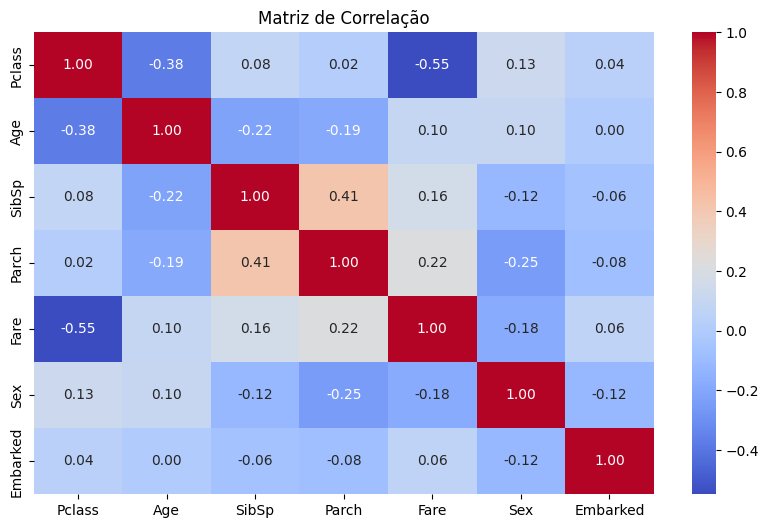

In [1377]:
# Matriz de correlação
correlation_matrix = train_df_normalized.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

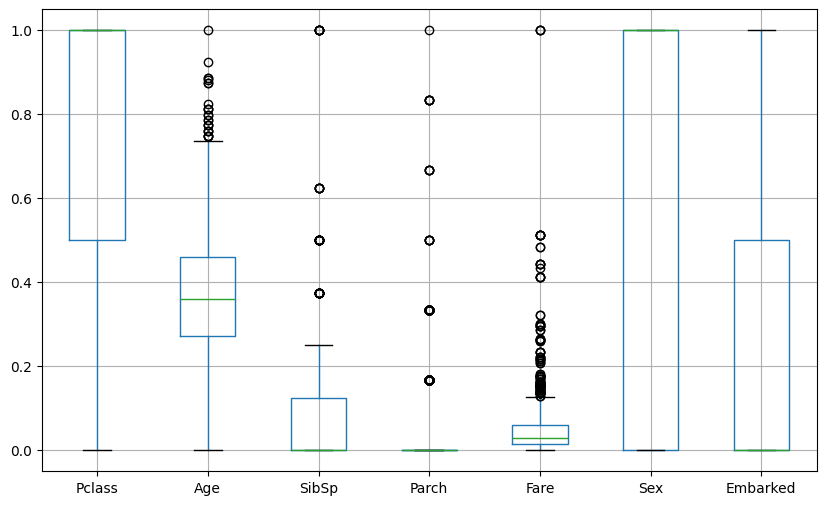

In [1378]:
train_df_normalized.boxplot(figsize=(10, 6))
plt.show()

# Visualizando os métodos para escolher o valor de k

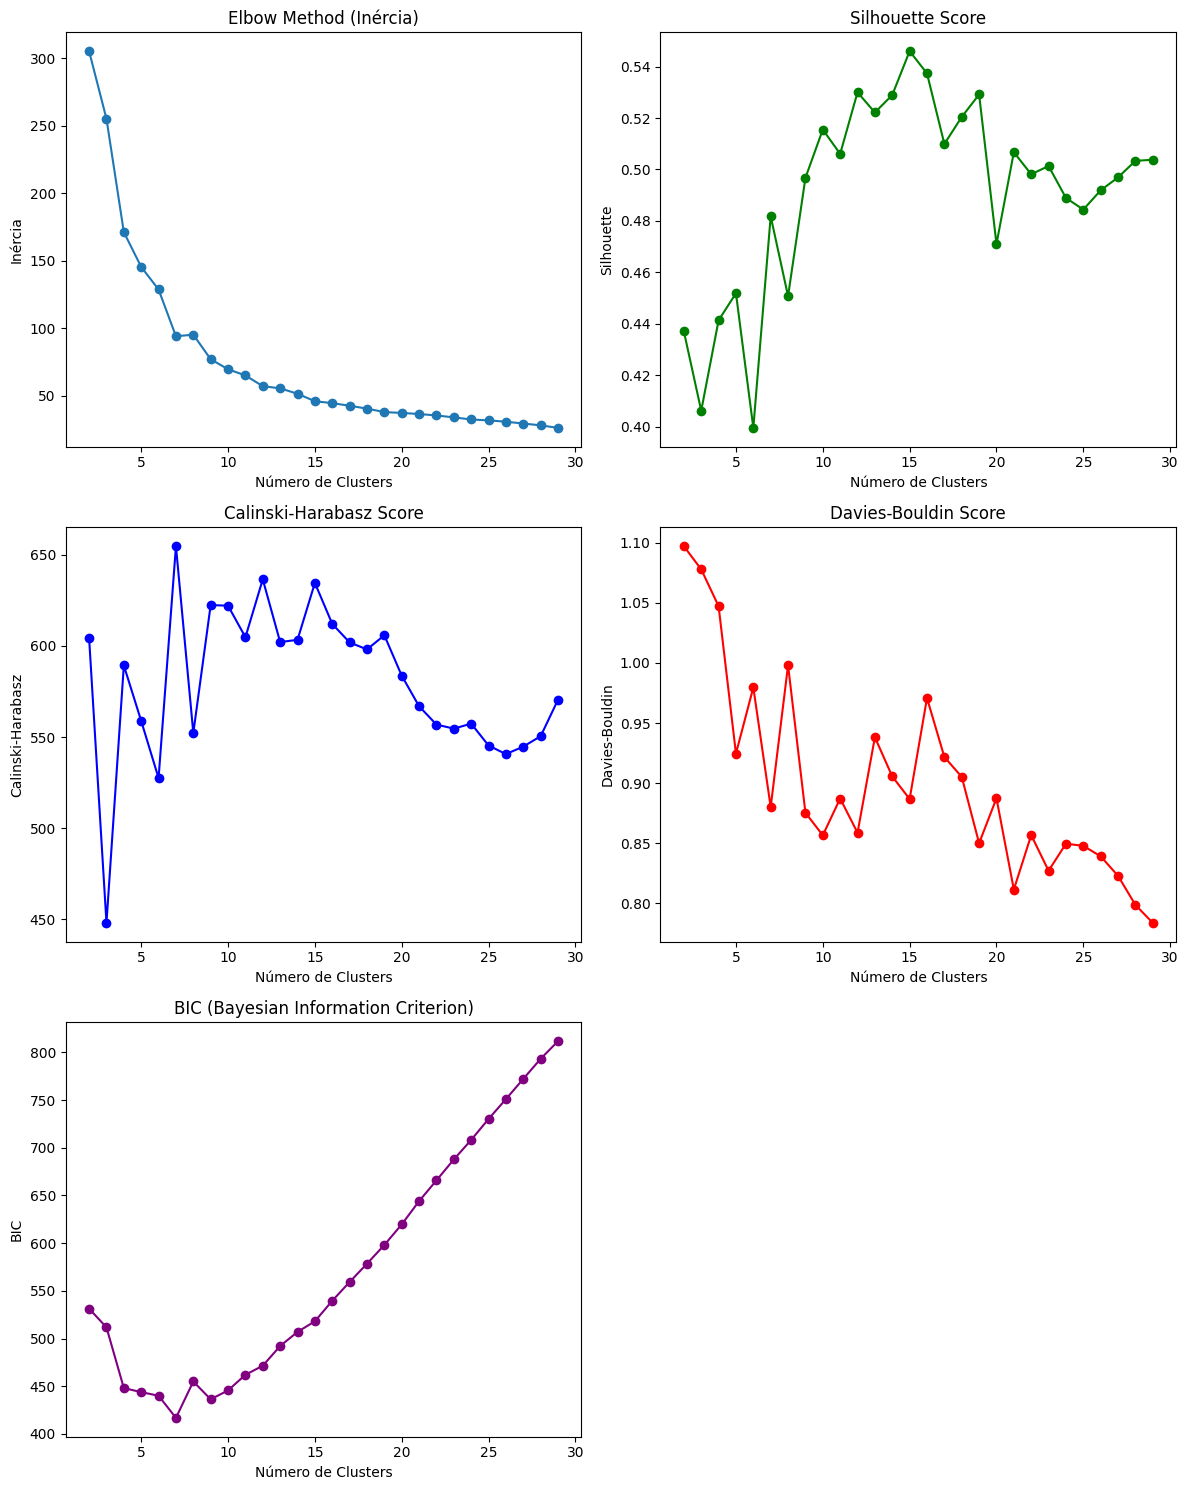

In [1379]:
def bic_kmeans(kmeans, X):
    """Calcula o BIC para um modelo K-Means."""
    n = X.shape[0]  # Número de amostras
    d = X.shape[1]  # Dimensão dos dados
    k = kmeans.n_clusters  # Número de clusters
    cluster_labels = kmeans.labels_
    log_likelihood = -0.5 * np.sum([np.sum(cdist(X[cluster_labels == i], [kmeans.cluster_centers_[i]]))
                                    for i in range(k)])
    penalty = 0.5 * k * np.log(n) * d
    return -2 * log_likelihood + penalty

# Intervalo de K para testar
k_values = range(2, 30)

# Listas para armazenar os resultados
inertia = []
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
bic_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(train_df_normalized)

    # Métricas
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(train_df_normalized, cluster_labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(train_df_normalized, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(train_df_normalized, cluster_labels))
    bic_scores.append(bic_kmeans(kmeans, train_df_normalized))

# 📌 Plotando os resultados
fig, axs = plt.subplots(3, 2, figsize=(12, 15))  # 3 linhas, 2 colunas

# Elbow Method (Inércia)
axs[0, 0].plot(k_values, inertia, marker='o')
axs[0, 0].set_title('Elbow Method (Inércia)')
axs[0, 0].set_xlabel('Número de Clusters')
axs[0, 0].set_ylabel('Inércia')

# Silhouette Score
axs[0, 1].plot(k_values, silhouette_scores, marker='o', color='g')
axs[0, 1].set_title('Silhouette Score')
axs[0, 1].set_xlabel('Número de Clusters')
axs[0, 1].set_ylabel('Silhouette')

# Calinski-Harabasz Score
axs[1, 0].plot(k_values, calinski_harabasz_scores, marker='o', color='b')
axs[1, 0].set_title('Calinski-Harabasz Score')
axs[1, 0].set_xlabel('Número de Clusters')
axs[1, 0].set_ylabel('Calinski-Harabasz')

# Davies-Bouldin Score
axs[1, 1].plot(k_values, davies_bouldin_scores, marker='o', color='r')
axs[1, 1].set_title('Davies-Bouldin Score')
axs[1, 1].set_xlabel('Número de Clusters')
axs[1, 1].set_ylabel('Davies-Bouldin')

# BIC
axs[2, 0].plot(k_values, bic_scores, marker='o', color='purple')
axs[2, 0].set_title('BIC (Bayesian Information Criterion)')
axs[2, 0].set_xlabel('Número de Clusters')
axs[2, 0].set_ylabel('BIC')

# Deixar o último subplot vazio ou removê-lo
axs[2, 1].axis('off')

plt.tight_layout()
plt.show()

In [1380]:
melhores_k = {
    "Elbow (Inércia)": 7,
    "Silhouette Score": 15,
    "Calinski-Harabasz Score":7,
    "Davies-Bouldin Score": 29,
    "BIC (Bayesian Information Criterion)": 7
}

# Função de visualização dos clusters

In [1381]:
def visualize_clusters(train_df_normalized):
    # Ignorar warnings
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)

    # Função para criar o gráfico
    def plot_embedding(data, title, xlabel, ylabel):
        plt.figure(figsize=(10, 6))
        plt.scatter(data['Dim1'], data['Dim2'], c=data['cluster'], cmap='viridis', alpha=0.5, s=10)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    # PCA
    pca = PCA(n_components=2)
    train_df_pca = pca.fit_transform(train_df_normalized.drop(columns=['cluster']))

    train_df_pca = pd.DataFrame(train_df_pca, columns=['PC1', 'PC2'])
    train_df_pca['cluster'] = train_df_normalized['cluster']

    # Plot PCA
    plt.figure(figsize=(10, 6))
    plt.scatter(train_df_pca['PC1'], train_df_pca['PC2'], c=train_df_pca['cluster'], cmap='viridis', alpha=0.5, s=10)
    plt.title('Visualização dos Clusters com PCA')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.show()

    # t-SNE (ajustando o perplexity)
    tsne = TSNE(n_components=2, random_state=42)  # Defina o perplexity conforme necessário
    train_df_tsne = tsne.fit_transform(train_df_normalized.drop(columns=['cluster']))

    train_df_tsne = pd.DataFrame(train_df_tsne, columns=['Dim1', 'Dim2'])
    train_df_tsne['cluster'] = train_df_normalized['cluster']

    # Plot t-SNE
    plot_embedding(train_df_tsne, 'Visualização dos Clusters com t-SNE', 'Dimensão 1', 'Dimensão 2')

    # UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    train_df_umap = reducer.fit_transform(train_df_normalized.drop(columns=['cluster']))

    train_df_umap = pd.DataFrame(train_df_umap, columns=['Dim1', 'Dim2'])
    train_df_umap['cluster'] = train_df_normalized['cluster']

    # Plot UMAP
    plot_embedding(train_df_umap, 'Visualização dos Clusters com UMAP', 'Dimensão 1', 'Dimensão 2')

In [1382]:
def analisar_clusters(df, cluster_col='cluster', max_variaveis=12, salvar_plots=False):
    """
    Analisa estatísticas e gera visualizações para clusters em um DataFrame.

    Parâmetros:
    -----------
    df : DataFrame
        DataFrame contendo os dados e a coluna de clusters
    cluster_col : str (padrão='cluster')
        Nome da coluna que identifica os clusters
    max_variaveis : int (padrão=12)
        Número máximo de variáveis a plotar nos gráficos individuais
    salvar_plots : bool (padrão=False)
        Se True, salva os plots em arquivos .png

    Retorna:
    --------
    dict
        Dicionário contendo DataFrames com estatísticas calculadas
    """

    resultados = {}

    # 1. Contagem de observações por cluster
    contagens = df[cluster_col].value_counts().sort_index()
    resultados['contagem'] = contagens

    print("\n=== CONTAGEM POR CLUSTER ===\n")
    print(contagens)

    plt.figure(figsize=(8, 4))
    sns.barplot(x=contagens.index, y=contagens.values, palette='viridis')
    plt.title('Distribuição de Observações por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Contagem')
    if salvar_plots:
        plt.savefig('contagem_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Estatísticas descritivas
    stats = df.groupby(cluster_col).describe(percentiles=[.25, .5, .75])
    resultados['estatisticas'] = stats

    print("\n=== ESTATÍSTICAS DESCRITIVAS ===\n")
    with pd.option_context('display.max_columns', None):
        print(stats.T.head(20))  # Mostrando só as primeiras 20 linhas para não poluir

    # 3. Médias por cluster
    medias = df.groupby(cluster_col).mean()
    resultados['medias'] = medias

    print("\n=== MÉDIAS POR CLUSTER ===\n")
    print(medias.style.background_gradient(cmap='viridis'))

    # 4. Boxplots para variáveis numéricas
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_cols = [col for col in numeric_cols if col != cluster_col]

    # Limitando o número de variáveis para plotar
    variaveis_plot = numeric_cols[:max_variaveis]

    plt.figure(figsize=(15, 8))
    for i, col in enumerate(variaveis_plot):
        plt.subplot(3, 4, i+1)
        sns.boxplot(x=cluster_col, y=col, data=df)
        plt.title(col)
    plt.tight_layout()
    if salvar_plots:
        plt.savefig('boxplots_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 5. Identificar variáveis mais discriminantes
    std_por_cluster = df.groupby(cluster_col).std()
    mean_std = std_por_cluster.mean().sort_values(ascending=False)
    resultados['variaveis_discriminantes'] = mean_std

    print("\n=== VARIÁVEIS COM MAIOR VARIAÇÃO ENTRE CLUSTERS ===\n")
    print(mean_std.head(10))

    return resultados

# Aplicação do K-Means


In [1383]:
num_clusters = 7  # Ajuste conforme necessário
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
train_df_normalized['cluster'] = kmeans.fit_predict(train_df_normalized)

In [1384]:
# Ajustar para exibir todas as colunas e linhas
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.max_rows', None)     # Mostrar todas as linhas
pd.set_option('display.width', None)        # Ajustar a largura para não cortar
pd.set_option('display.max_colwidth', None) # Ajustar o tamanho máximo da coluna

In [1385]:
# Distâncias intra-cluster
intra_cluster_distances = []
for i in range(num_clusters):
    cluster_points = train_df_normalized[train_df_normalized['cluster'] == i].drop('cluster', axis=1)
    # Calcula as distâncias entre os pontos dentro do cluster
    distances = pairwise_distances(cluster_points)
    # A distância intra-cluster é a média das distâncias entre todos os pares de pontos
    intra_cluster_distances.append(np.mean(distances))

# Distância intra-cluster média geral
intra_cluster_average = np.mean(intra_cluster_distances)

# Distâncias entre-cluster
centroids = kmeans.cluster_centers_
between_cluster_distances = pairwise_distances(centroids)

# Distância entre-cluster média geral
between_cluster_average = np.mean(between_cluster_distances[np.triu_indices(num_clusters, 1)])

# Exibindo resultados
print(f"Distância intra-cluster média geral: {intra_cluster_average}")
print(f"Distância entre-cluster média geral: {between_cluster_average}")

Distância intra-cluster média geral: 0.4049502536649206
Distância entre-cluster média geral: 1.0683663830559615


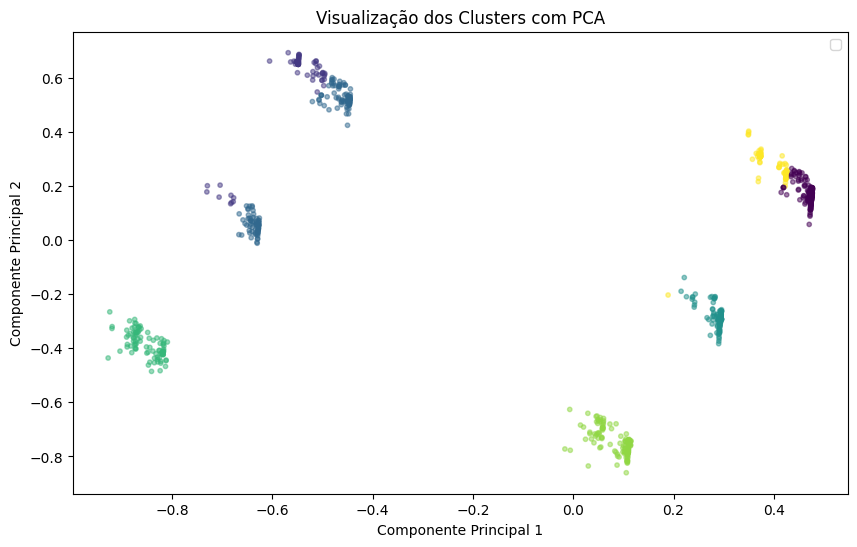

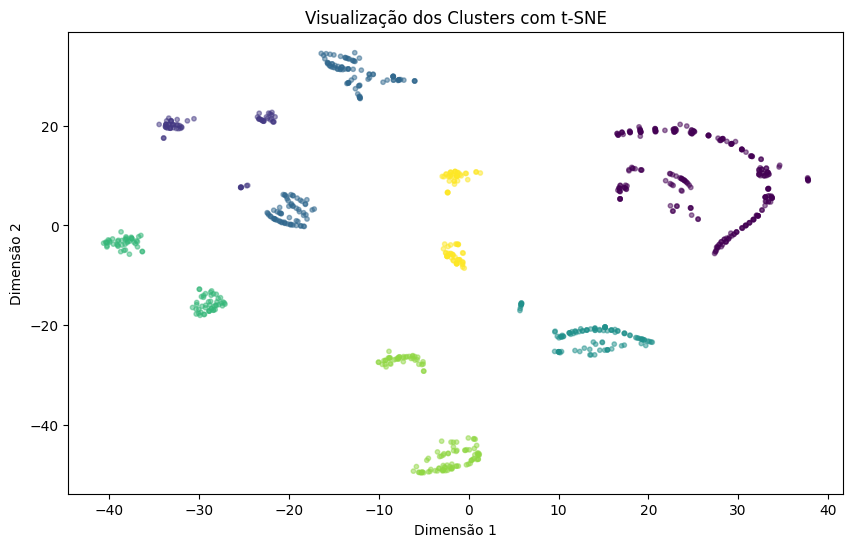

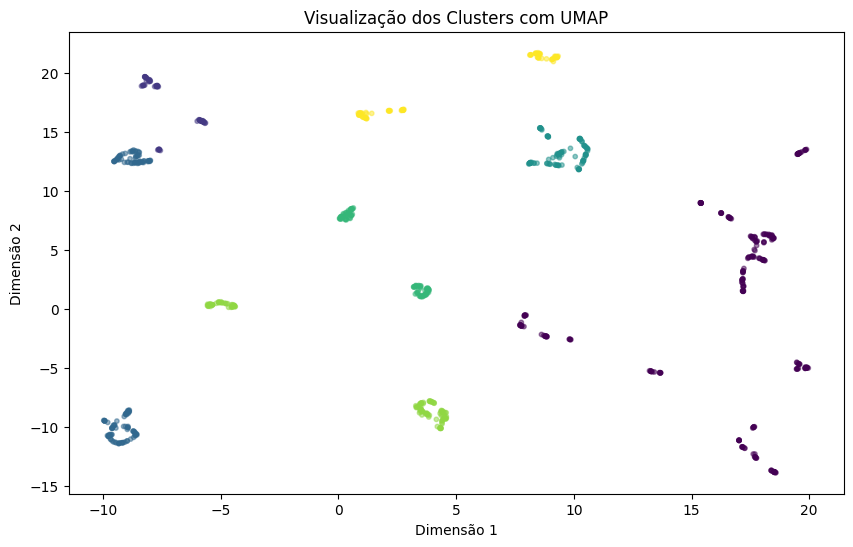

In [1386]:
visualize_clusters(train_df_normalized)


=== CONTAGEM POR CLUSTER ===

cluster
0    265
1     65
2    155
3    107
4     92
5    122
6     83
Name: count, dtype: int64


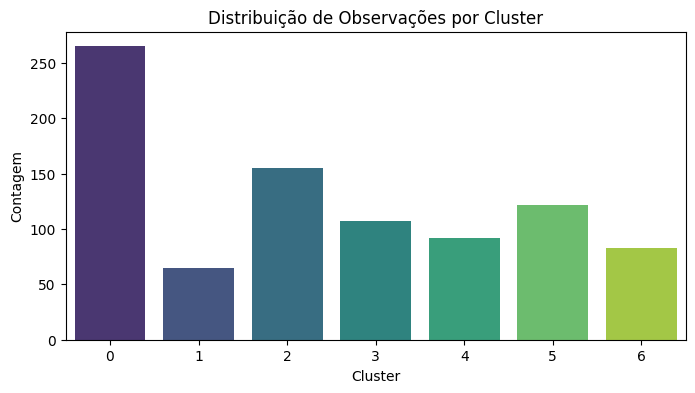


=== ESTATÍSTICAS DESCRITIVAS ===

cluster                0          1           2           3          4           5          6
Pclass count  265.000000  65.000000  155.000000  107.000000  92.000000  122.000000  83.000000
       mean     1.000000   0.930769    0.783871    0.500000   0.000000    0.000000   0.993976
       std      0.000000   0.174036    0.248498    0.000000   0.000000    0.000000   0.054882
       min      1.000000   0.500000    0.500000    0.500000   0.000000    0.000000   0.500000
       25%      1.000000   1.000000    0.500000    0.500000   0.000000    0.000000   1.000000
       50%      1.000000   1.000000    1.000000    0.500000   0.000000    0.000000   1.000000
       75%      1.000000   1.000000    1.000000    0.500000   0.000000    0.000000   1.000000
       max      1.000000   1.000000    1.000000    0.500000   0.000000    0.000000   1.000000
Age    count  265.000000  65.000000  155.000000  107.000000  92.000000  122.000000  83.000000
       mean     0.333055 

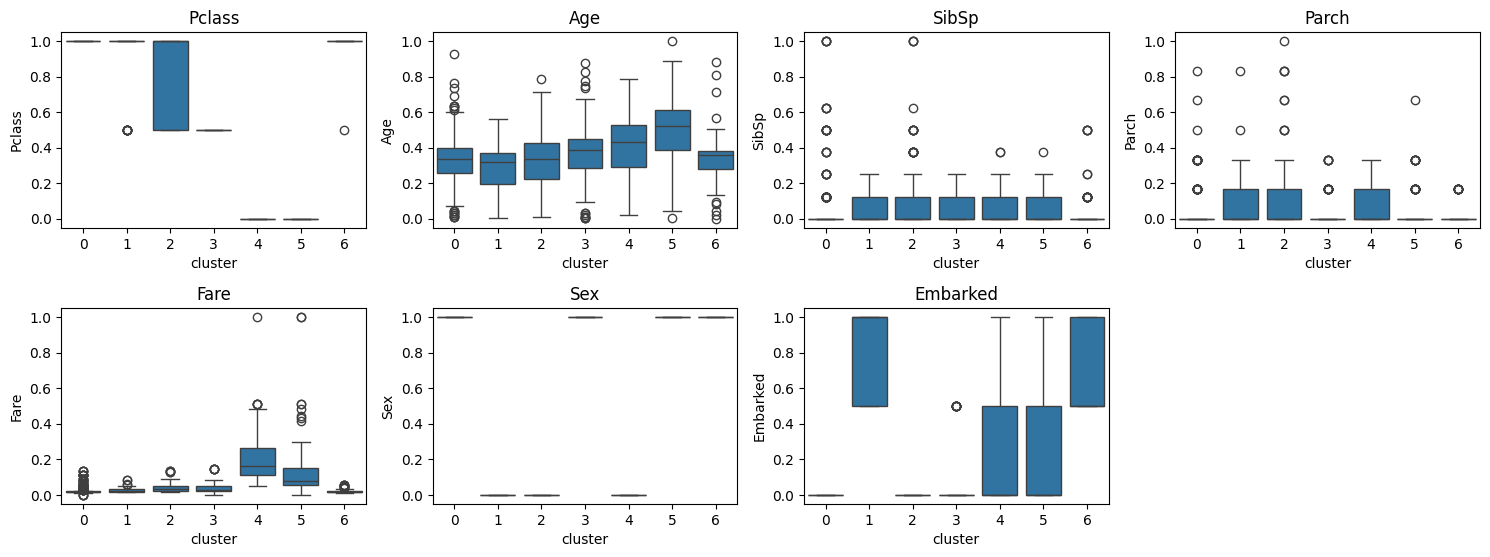


=== VARIÁVEIS COM MAIOR VARIAÇÃO ENTRE CLUSTERS ===

Embarked    0.165757
Age         0.153965
Parch       0.120138
SibSp       0.110457
Pclass      0.068202
Fare        0.057626
Sex         0.000000
dtype: float64

=== CONTAGEM POR CLUSTER ===

cluster
0    265
1     65
2    155
3    107
4     92
5    122
6     83
Name: count, dtype: int64


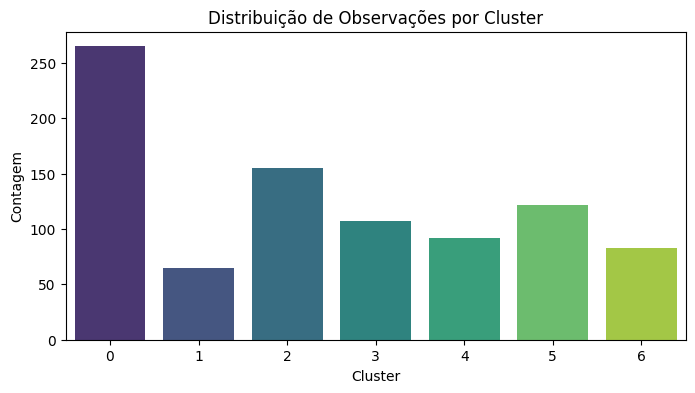


=== ESTATÍSTICAS DESCRITIVAS ===

cluster                0          1           2           3          4           5          6
Pclass count  265.000000  65.000000  155.000000  107.000000  92.000000  122.000000  83.000000
       mean     1.000000   0.930769    0.783871    0.500000   0.000000    0.000000   0.993976
       std      0.000000   0.174036    0.248498    0.000000   0.000000    0.000000   0.054882
       min      1.000000   0.500000    0.500000    0.500000   0.000000    0.000000   0.500000
       25%      1.000000   1.000000    0.500000    0.500000   0.000000    0.000000   1.000000
       50%      1.000000   1.000000    1.000000    0.500000   0.000000    0.000000   1.000000
       75%      1.000000   1.000000    1.000000    0.500000   0.000000    0.000000   1.000000
       max      1.000000   1.000000    1.000000    0.500000   0.000000    0.000000   1.000000
Age    count  265.000000  65.000000  155.000000  107.000000  92.000000  122.000000  83.000000
       mean     0.333055 

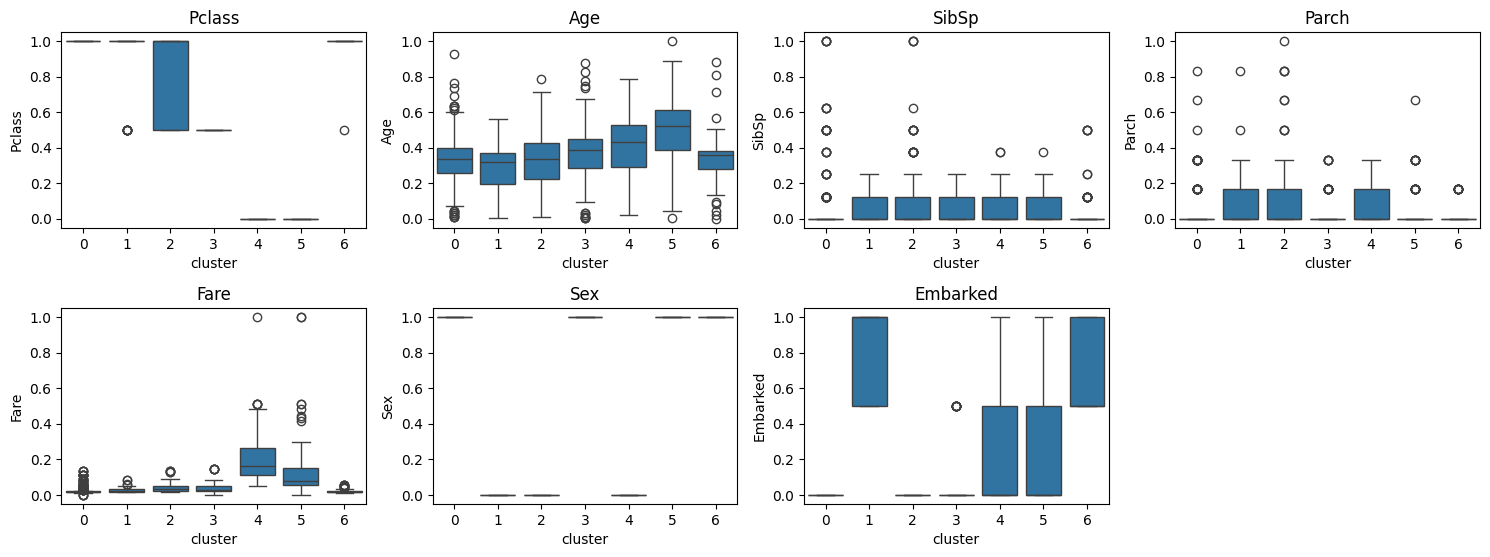


=== VARIÁVEIS COM MAIOR VARIAÇÃO ENTRE CLUSTERS ===

Embarked    0.165757
Age         0.153965
Parch       0.120138
SibSp       0.110457
Pclass      0.068202
Fare        0.057626
Sex         0.000000
dtype: float64

=== CONTAGEM POR CLUSTER ===

cluster
0    265
1     65
2    155
3    107
4     92
5    122
6     83
Name: count, dtype: int64


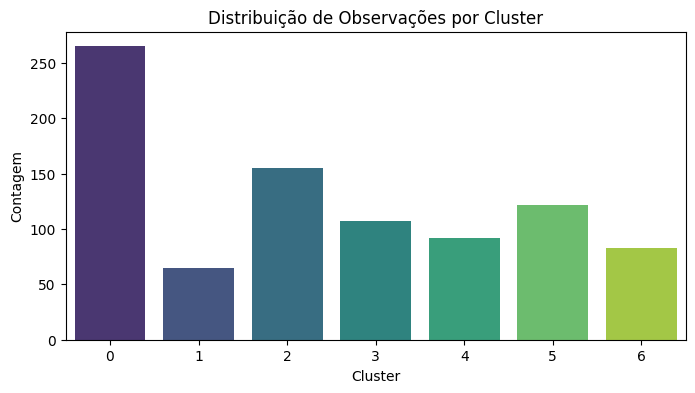


=== ESTATÍSTICAS DESCRITIVAS ===

cluster                0          1           2           3          4           5          6
Pclass count  265.000000  65.000000  155.000000  107.000000  92.000000  122.000000  83.000000
       mean     1.000000   0.930769    0.783871    0.500000   0.000000    0.000000   0.993976
       std      0.000000   0.174036    0.248498    0.000000   0.000000    0.000000   0.054882
       min      1.000000   0.500000    0.500000    0.500000   0.000000    0.000000   0.500000
       25%      1.000000   1.000000    0.500000    0.500000   0.000000    0.000000   1.000000
       50%      1.000000   1.000000    1.000000    0.500000   0.000000    0.000000   1.000000
       75%      1.000000   1.000000    1.000000    0.500000   0.000000    0.000000   1.000000
       max      1.000000   1.000000    1.000000    0.500000   0.000000    0.000000   1.000000
Age    count  265.000000  65.000000  155.000000  107.000000  92.000000  122.000000  83.000000
       mean     0.333055 

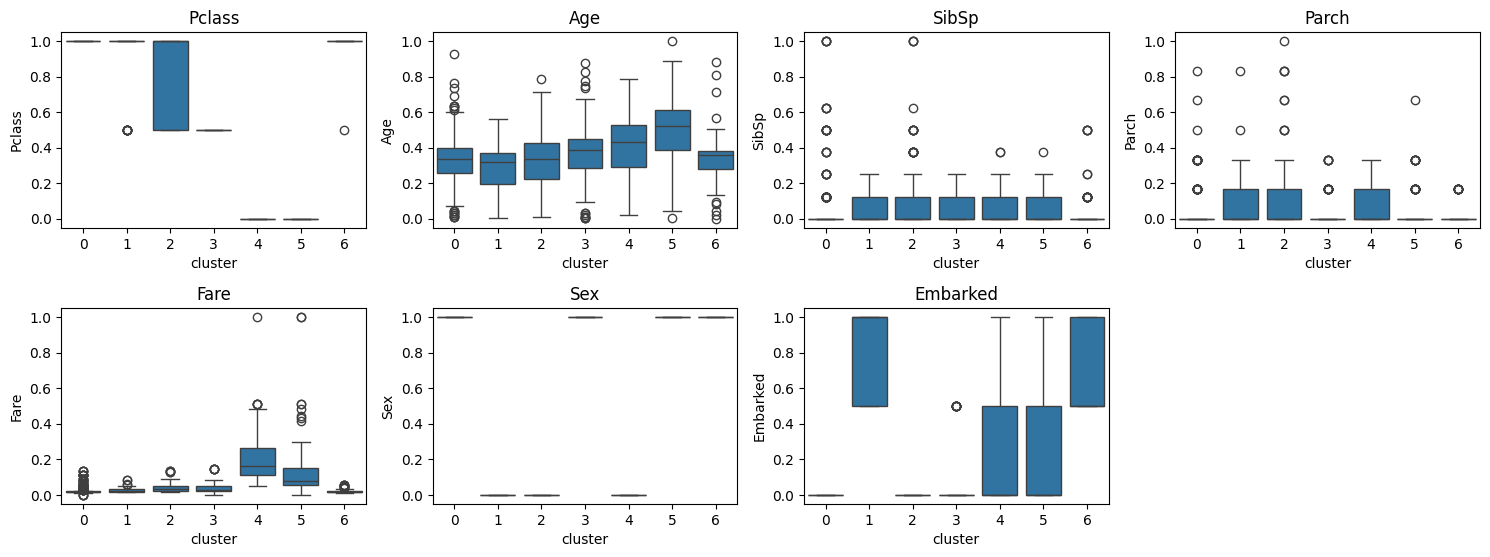


=== VARIÁVEIS COM MAIOR VARIAÇÃO ENTRE CLUSTERS ===

Embarked    0.165757
Age         0.153965
Parch       0.120138
SibSp       0.110457
Pclass      0.068202
Fare        0.057626
Sex         0.000000
dtype: float64
           Pclass       Age     SibSp     Parch      Fare  Sex  Embarked
cluster                                                                 
0        1.000000  0.333055  0.066038  0.042138  0.025974  1.0  0.000000
1        0.930769  0.284027  0.048077  0.079487  0.026417  0.0  0.769231
2        0.783871  0.325256  0.113710  0.139785  0.039177  0.0  0.000000
3        0.500000  0.381535  0.043224  0.037383  0.038668  1.0  0.046729
4        0.000000  0.424831  0.070652  0.077899  0.208252  0.0  0.244565
5        0.000000  0.514255  0.038934  0.046448  0.131217  1.0  0.180328
6        0.993976  0.339669  0.049699  0.022088  0.020684  1.0  0.740964
Embarked    0.165757
Age         0.153965
Parch       0.120138
SibSp       0.110457
Pclass      0.068202
dtype: float64


In [1387]:
resultados = analisar_clusters(train_df_normalized, cluster_col='cluster')
# Análise básica
resultados = analisar_clusters(train_df_normalized)

# Personalizando
resultados = analisar_clusters(
    train_df_normalized,
    cluster_col='cluster',
    max_variaveis=8,
    salvar_plots=True
)

# Acessando resultados específicos depois
print(resultados['medias'])
print(resultados['variaveis_discriminantes'].head(5))

# Aplicando DBSCAN:

In [1388]:
# Ajuste os parâmetros conforme necessário
eps_value = 0.5  # Distância máxima entre pontos para formar um cluster
min_samples_value = 5  # Número mínimo de pontos para formar um cluster

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
train_df_normalized['cluster'] = dbscan.fit_predict(train_df_normalized)

In [1389]:
# Contar o número de clusters excluindo o ruído (-1)
num_clusters = len(set(train_df_normalized['cluster']) - {-1})

print(f'O número de clusters formados pelo DBSCAN é: {num_clusters}')

O número de clusters formados pelo DBSCAN é: 14


In [1390]:
# Distâncias intra-cluster
intra_cluster_distances = []
unique_clusters = np.unique(train_df_normalized['cluster'])

for cluster_id in unique_clusters:
    if cluster_id == -1:  # Ignora pontos de ruído
        continue

    # Seleciona os pontos pertencentes ao cluster
    cluster_points = train_df_normalized[train_df_normalized['cluster'] == cluster_id].drop('cluster', axis=1)

    # Calcula as distâncias entre todos os pontos dentro do cluster
    distances = pairwise_distances(cluster_points)

    # A distância intra-cluster é a média das distâncias entre todos os pares de pontos
    intra_cluster_distances.append(np.mean(distances))

# Distância intra-cluster média geral
intra_cluster_average = np.mean(intra_cluster_distances)

# Distâncias entre-cluster
# Calcula a distância média entre todos os pares de pontos de diferentes clusters
between_cluster_distances = []
for i in range(len(unique_clusters)):
    for j in range(i + 1, len(unique_clusters)):
        cluster_i = unique_clusters[i]
        cluster_j = unique_clusters[j]

        if cluster_i == -1 or cluster_j == -1:  # Ignora os pontos de ruído
            continue

        # Seleciona os pontos de cada cluster
        cluster_i_points = train_df_normalized[train_df_normalized['cluster'] == cluster_i].drop('cluster', axis=1)
        cluster_j_points = train_df_normalized[train_df_normalized['cluster'] == cluster_j].drop('cluster', axis=1)

        # Calcula as distâncias entre os pontos de cada cluster
        distances = pairwise_distances(cluster_i_points, cluster_j_points)

        # A distância entre-cluster é a média das distâncias entre todos os pares de pontos entre os clusters
        between_cluster_distances.append(np.mean(distances))

# Distância entre-cluster média geral
between_cluster_average = np.mean(between_cluster_distances)

# Exibindo resultados
print(f"Distância intra-cluster média geral: {intra_cluster_average}")
print(f"Distância entre-cluster média geral: {between_cluster_average}")

Distância intra-cluster média geral: 0.2600226045404654
Distância entre-cluster média geral: 1.0975623264737937


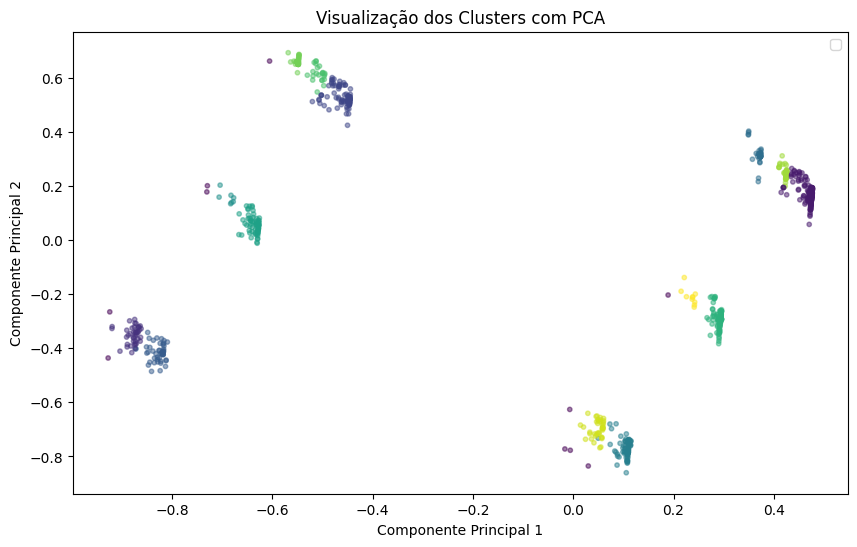

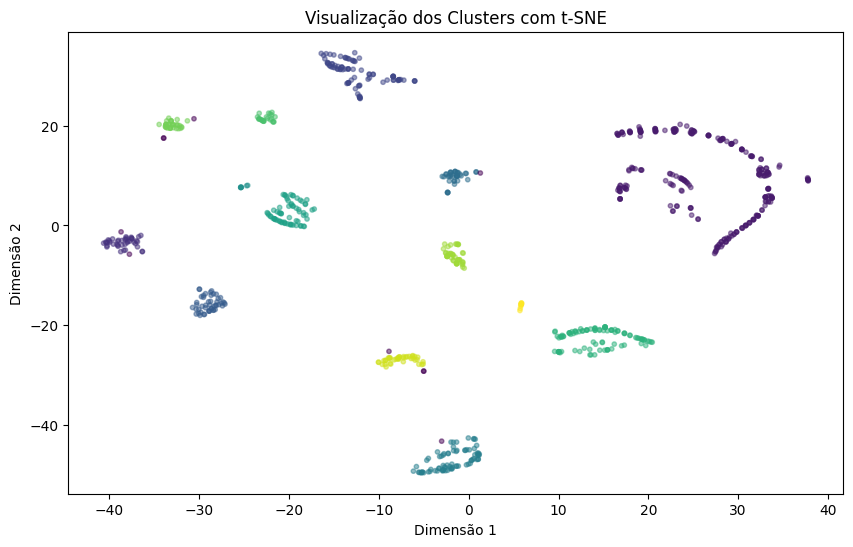

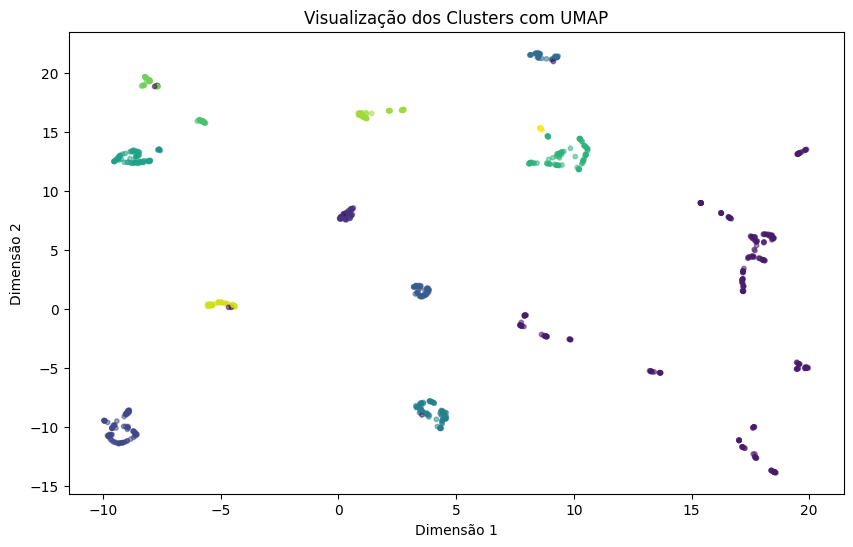

In [1391]:
visualize_clusters(train_df_normalized)


=== CONTAGEM POR CLUSTER ===

cluster
-1      10
 0     265
 1      42
 2      88
 3      48
 4      39
 5      78
 6       7
 7      67
 8      97
 9      23
 10     32
 11     43
 12     40
 13     10
Name: count, dtype: int64


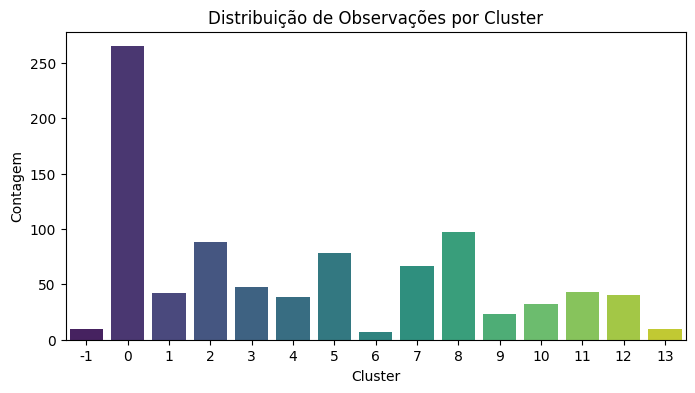


=== ESTATÍSTICAS DESCRITIVAS ===

cluster             -1           0          1          2          3          4          5   \
Pclass count  10.000000  265.000000  42.000000  88.000000  48.000000  39.000000  78.000000   
       mean    0.250000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       std     0.353553    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
       min     0.000000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       25%     0.000000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       50%     0.000000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       75%     0.500000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       max     1.000000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
Age    count  10.000000  265.000000  42.000000  88.000000  48.000000  39.000000  78.000000   
       mean    0.513446  

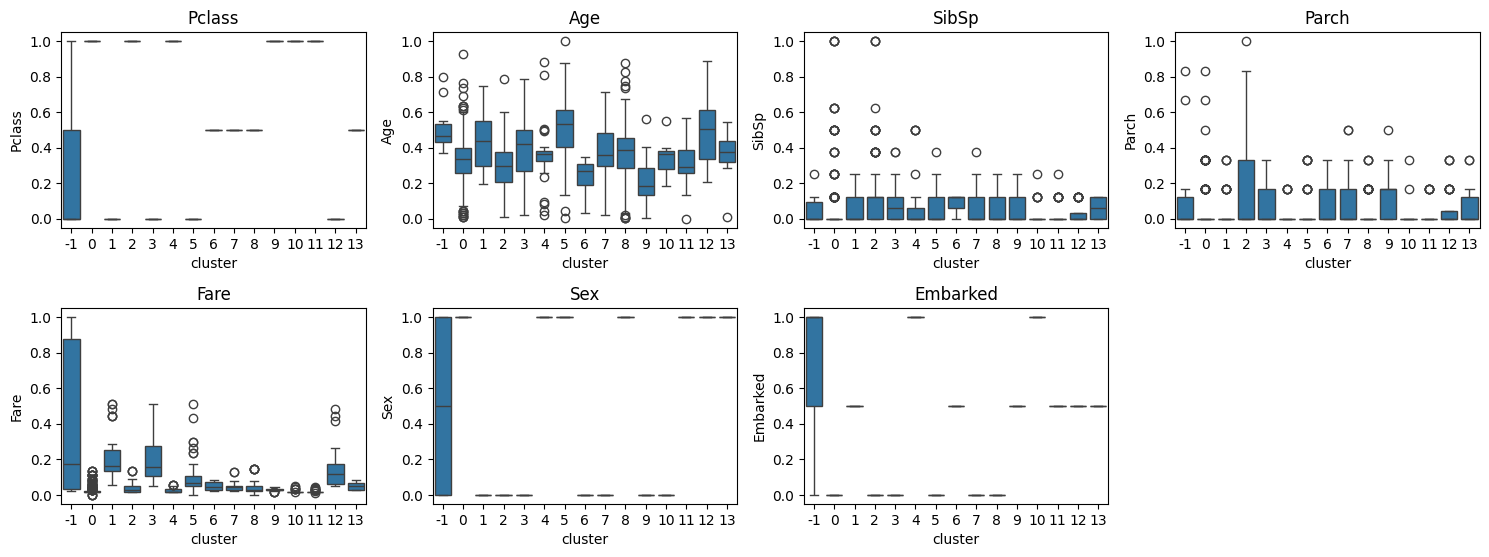


=== VARIÁVEIS COM MAIOR VARIAÇÃO ENTRE CLUSTERS ===

Age         0.146059
Parch       0.128894
SibSp       0.095270
Fare        0.071074
Sex         0.035136
Pclass      0.023570
Embarked    0.023570
dtype: float64

=== CONTAGEM POR CLUSTER ===

cluster
-1      10
 0     265
 1      42
 2      88
 3      48
 4      39
 5      78
 6       7
 7      67
 8      97
 9      23
 10     32
 11     43
 12     40
 13     10
Name: count, dtype: int64


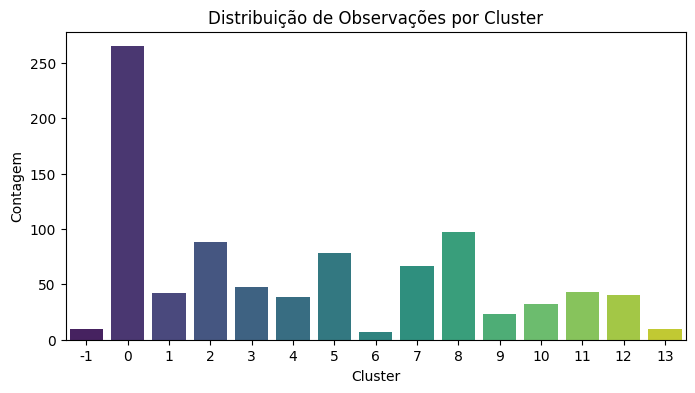


=== ESTATÍSTICAS DESCRITIVAS ===

cluster             -1           0          1          2          3          4          5   \
Pclass count  10.000000  265.000000  42.000000  88.000000  48.000000  39.000000  78.000000   
       mean    0.250000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       std     0.353553    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
       min     0.000000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       25%     0.000000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       50%     0.000000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       75%     0.500000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       max     1.000000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
Age    count  10.000000  265.000000  42.000000  88.000000  48.000000  39.000000  78.000000   
       mean    0.513446  

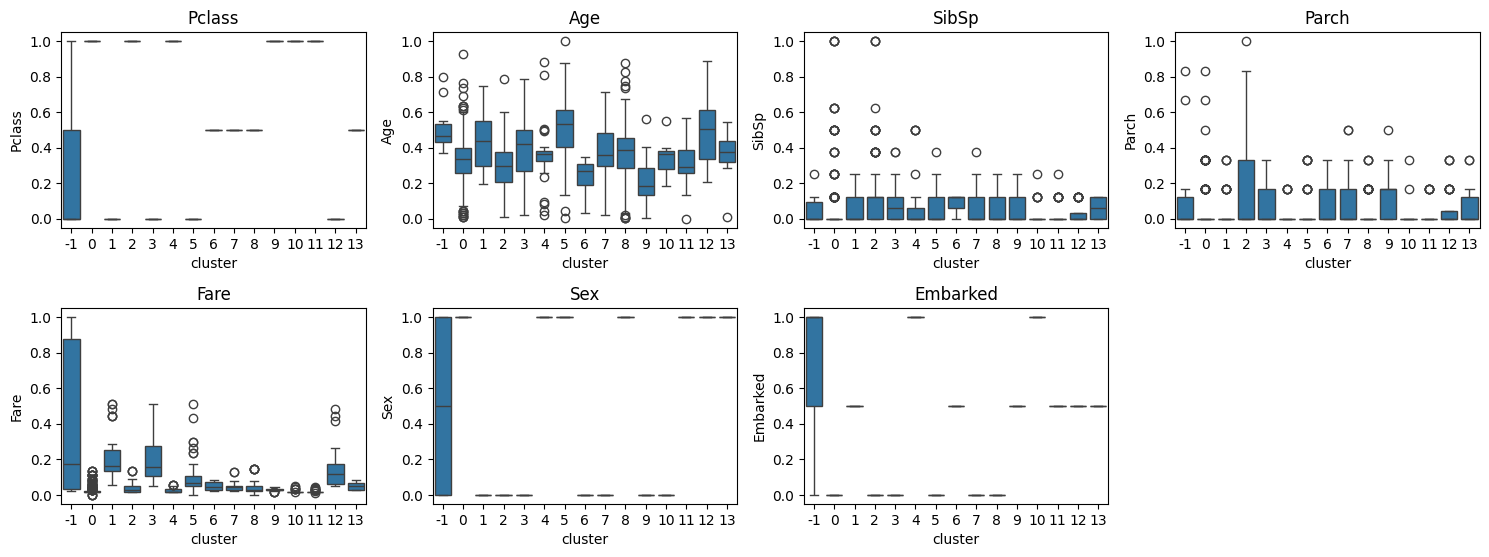


=== VARIÁVEIS COM MAIOR VARIAÇÃO ENTRE CLUSTERS ===

Age         0.146059
Parch       0.128894
SibSp       0.095270
Fare        0.071074
Sex         0.035136
Pclass      0.023570
Embarked    0.023570
dtype: float64

=== CONTAGEM POR CLUSTER ===

cluster
-1      10
 0     265
 1      42
 2      88
 3      48
 4      39
 5      78
 6       7
 7      67
 8      97
 9      23
 10     32
 11     43
 12     40
 13     10
Name: count, dtype: int64


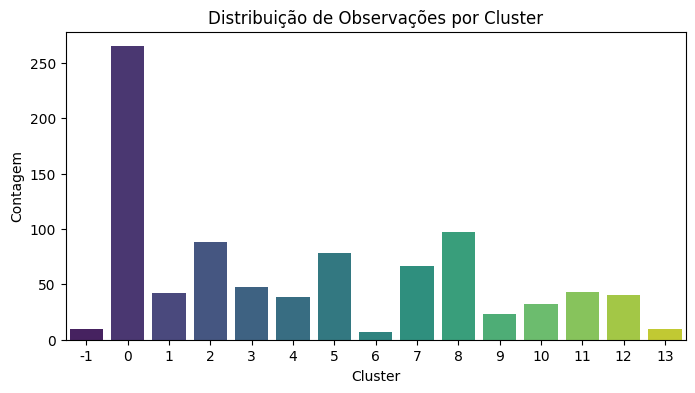


=== ESTATÍSTICAS DESCRITIVAS ===

cluster             -1           0          1          2          3          4          5   \
Pclass count  10.000000  265.000000  42.000000  88.000000  48.000000  39.000000  78.000000   
       mean    0.250000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       std     0.353553    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
       min     0.000000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       25%     0.000000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       50%     0.000000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       75%     0.500000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
       max     1.000000    1.000000   0.000000   1.000000   0.000000   1.000000   0.000000   
Age    count  10.000000  265.000000  42.000000  88.000000  48.000000  39.000000  78.000000   
       mean    0.513446  

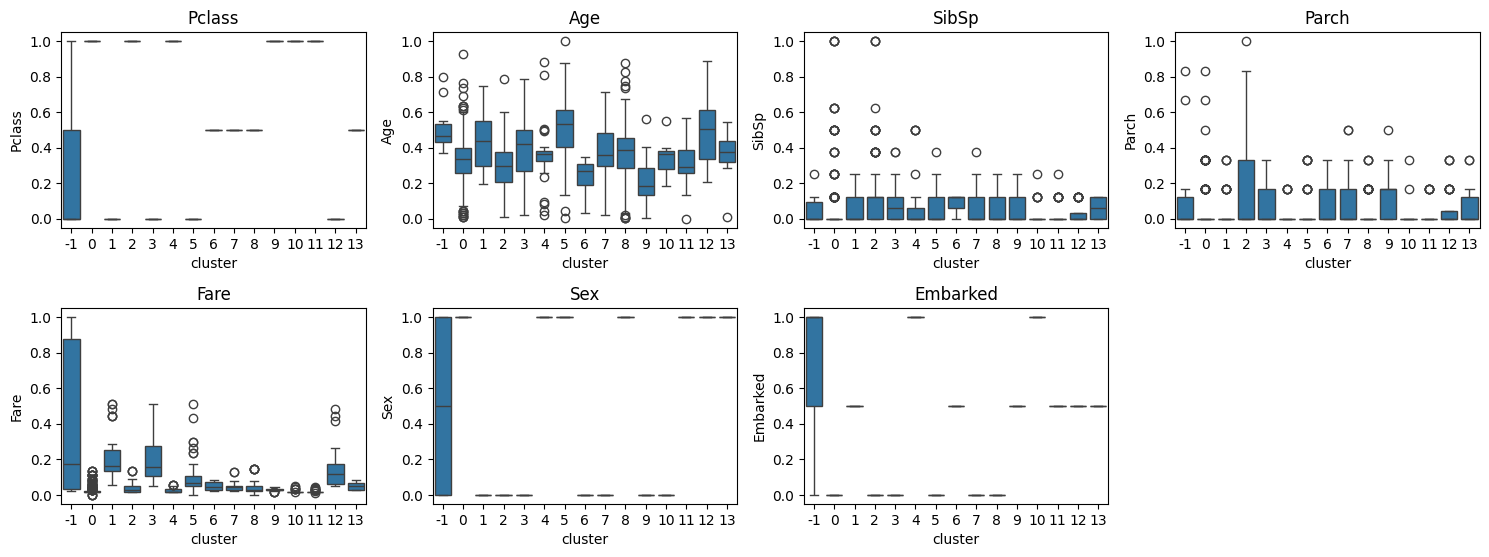


=== VARIÁVEIS COM MAIOR VARIAÇÃO ENTRE CLUSTERS ===

Age         0.146059
Parch       0.128894
SibSp       0.095270
Fare        0.071074
Sex         0.035136
Pclass      0.023570
Embarked    0.023570
dtype: float64
         Pclass       Age     SibSp     Parch      Fare  Sex  Embarked
cluster                                                               
-1         0.25  0.513446  0.050000  0.166667  0.399384  0.5      0.75
 0         1.00  0.333055  0.066038  0.042138  0.025974  1.0      0.00
 1         0.00  0.440271  0.065476  0.051587  0.207279  0.0      0.50
 2         1.00  0.291022  0.154830  0.166667  0.036442  0.0      0.00
 3         0.00  0.411441  0.075521  0.104167  0.193288  0.0      0.00
 4         1.00  0.361165  0.073718  0.021368  0.023275  1.0      1.00
 5         0.00  0.518179  0.040064  0.034188  0.098095  1.0      0.00
 6         0.50  0.235271  0.089286  0.095238  0.049321  0.0      0.50
 7         0.50  0.370220  0.059701  0.104478  0.042771  0.0      0.00
 8 

In [1392]:
resultados = analisar_clusters(train_df_normalized, cluster_col='cluster')
# Análise básica
resultados = analisar_clusters(train_df_normalized)

# Personalizando
resultados = analisar_clusters(
    train_df_normalized,
    cluster_col='cluster',
    max_variaveis=8,
    salvar_plots=True
)

# Acessando resultados específicos depois
print(resultados['medias'])
print(resultados['variaveis_discriminantes'].head(5))

# Carregando o dataset sem transformar as variáveis categóricas para o K-prototypes:

In [1393]:
# Carregando o dataset
train_df = pd.read_csv('/content/train.csv')

train_df = train_df.dropna(subset=['Sex', 'Embarked'])

# Removendo colunas irrelevantes
train_df = train_df.drop(['PassengerId', 'Name', 'Cabin', 'Ticket', 'Survived'], axis=1)

# Separando as colunas numéricas e categóricas
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train_df.select_dtypes(include=['object']).columns

# Mantendo as colunas categóricas sem normalização
train_df_categorical = train_df[categorical_cols]

train_df_categorical = train_df_categorical.reset_index(drop=True)

# Reunindo as colunas numéricas normalizadas com as categóricas
train_df_normalized = pd.concat([numerical, train_df_categorical], axis=1)

In [1394]:
print(train_df_normalized.isnull().sum())

Pclass      0
Age         0
SibSp       0
Parch       0
Fare        0
Sex         0
Embarked    0
dtype: int64


# Treinando o K-prototypes

In [1395]:
# Convertendo o DataFrame para uma matriz NumPy (K-Prototypes trabalha com arrays NumPy)
X = train_df_normalized.values

# Criando uma lista de índices para as colunas categóricas
categorical_columns = list(range(len(numerical_cols), X.shape[1]))  # As colunas categóricas vêm depois das numéricas

# Instanciando o modelo K-Prototypes
kproto = KPrototypes(n_clusters=7, init='Cao', n_init=10, verbose=2)

# Aplicando o K-Prototypes nos dados mistos (numéricos e categóricos)
train_df_normalized['cluster'] = kproto.fit_predict(X, categorical=categorical_columns)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 108, ncost: 76.1680893213483
Run: 1, iteration: 2/100, moves: 13, ncost: 76.12657707171579
Run: 1, iteration: 3/100, moves: 3, ncost: 76.11302319563801
Run: 1, iteration: 4/100, moves: 3, ncost: 76.10453361025242
Run: 1, iteration: 5/100, moves: 0, ncost: 76.10453361025242
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 226, ncost: 67.51384611044048
Run: 2, iteration: 2/100, moves: 27, ncost: 67.16250491365022
Run: 2, iteration: 3/100, moves: 0, ncost: 67.16250491365022
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 212, ncost: 77.72057730204358
Run: 3, iteration: 2/100, moves: 80, ncost: 74.58757039921171
Run: 3, iteration: 3/100, moves: 19, ncost: 74.33573913839633
Run:

In [1396]:
train_df_normalized['Sex'] = train_df_normalized['Sex'].map({'female': 0.0, 'male': 1.0})
train_df_normalized['Embarked'] = train_df_normalized['Embarked'].map({'S': 0.0, 'C': 0.5, 'Q': 1.0})

In [1397]:
print(train_df_normalized.head())

   Pclass       Age  SibSp  Parch      Fare  Sex  Embarked  cluster
0     1.0  0.271174  0.125    0.0  0.014151  1.0       0.0        4
1     0.0  0.472229  0.125    0.0  0.139136  0.0       0.5        3
2     1.0  0.321438  0.000    0.0  0.015469  0.0       0.0        1
3     0.0  0.434531  0.125    0.0  0.103644  0.0       0.0        0
4     1.0  0.434531  0.000    0.0  0.015713  1.0       0.0        4


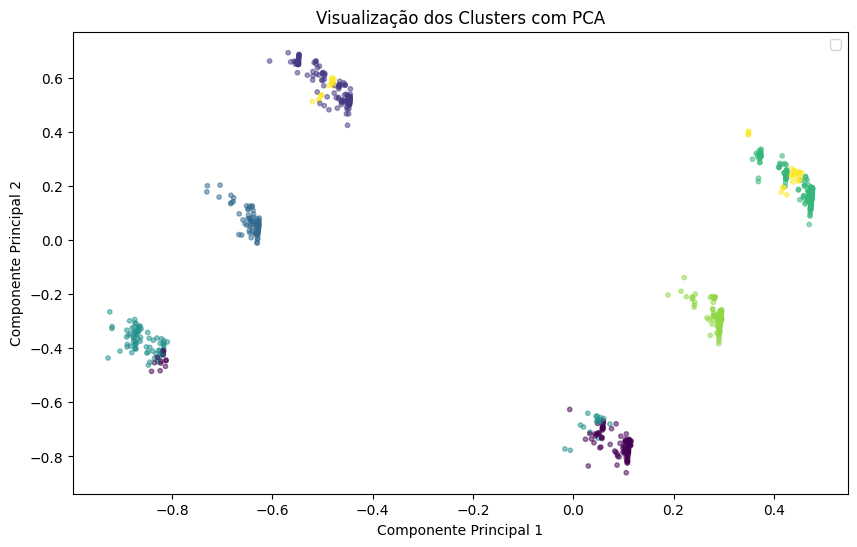

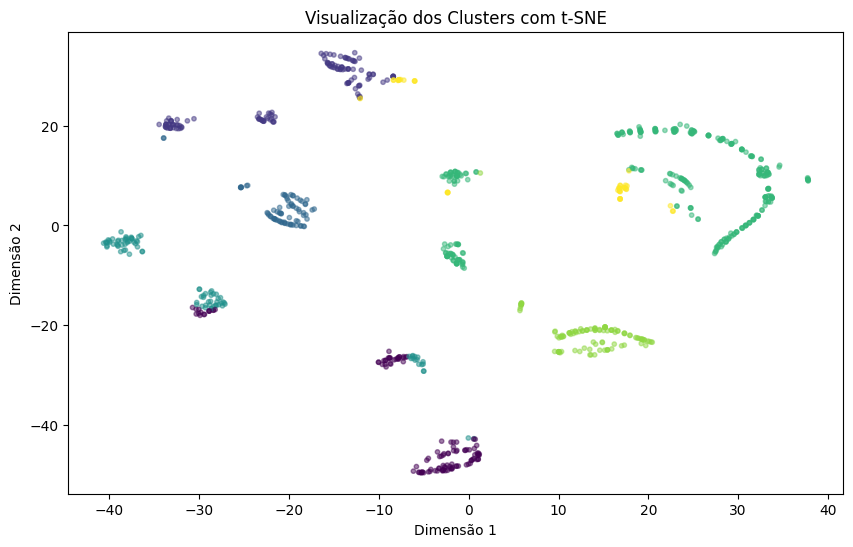

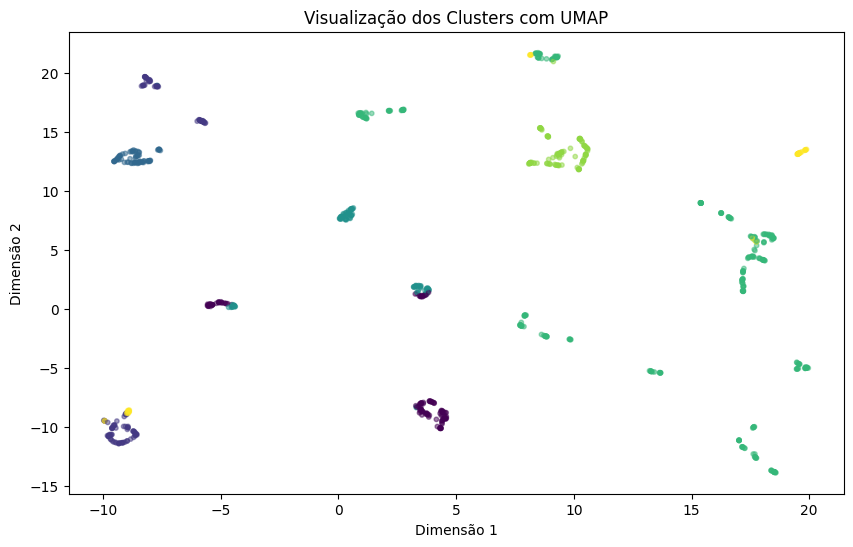

In [1398]:
visualize_clusters(train_df_normalized)

In [1399]:
# Distâncias intra-cluster
intra_cluster_distances = []
unique_clusters = np.unique(train_df_normalized['cluster'])

for cluster_id in unique_clusters:
    if cluster_id == -1:  # Ignora pontos de ruído
        continue

    # Seleciona os pontos pertencentes ao cluster
    cluster_points = train_df_normalized[train_df_normalized['cluster'] == cluster_id].drop('cluster', axis=1)

    # Calcula as distâncias entre todos os pontos dentro do cluster
    distances = pairwise_distances(cluster_points)

    # A distância intra-cluster é a média das distâncias entre todos os pares de pontos
    intra_cluster_distances.append(np.mean(distances))

# Distância intra-cluster média geral
intra_cluster_average = np.mean(intra_cluster_distances)

# Distâncias entre-cluster
# Calcula a distância média entre todos os pares de pontos de diferentes clusters
between_cluster_distances = []
for i in range(len(unique_clusters)):
    for j in range(i + 1, len(unique_clusters)):
        cluster_i = unique_clusters[i]
        cluster_j = unique_clusters[j]

        if cluster_i == -1 or cluster_j == -1:  # Ignora os pontos de ruído
            continue

        # Seleciona os pontos de cada cluster
        cluster_i_points = train_df_normalized[train_df_normalized['cluster'] == cluster_i].drop('cluster', axis=1)
        cluster_j_points = train_df_normalized[train_df_normalized['cluster'] == cluster_j].drop('cluster', axis=1)

        # Calcula as distâncias entre os pontos de cada cluster
        distances = pairwise_distances(cluster_i_points, cluster_j_points)

        # A distância entre-cluster é a média das distâncias entre todos os pares de pontos entre os clusters
        between_cluster_distances.append(np.mean(distances))

# Distância entre-cluster média geral
between_cluster_average = np.mean(between_cluster_distances)

# Exibindo resultados
print(f"Distância intra-cluster média geral: {intra_cluster_average}")
print(f"Distância entre-cluster média geral: {between_cluster_average}")

Distância intra-cluster média geral: 0.5318213134061466
Distância entre-cluster média geral: 1.1386016285308305



=== CONTAGEM POR CLUSTER ===

cluster
0    120
1    129
2     76
3     94
4    319
5    108
6     43
Name: count, dtype: int64


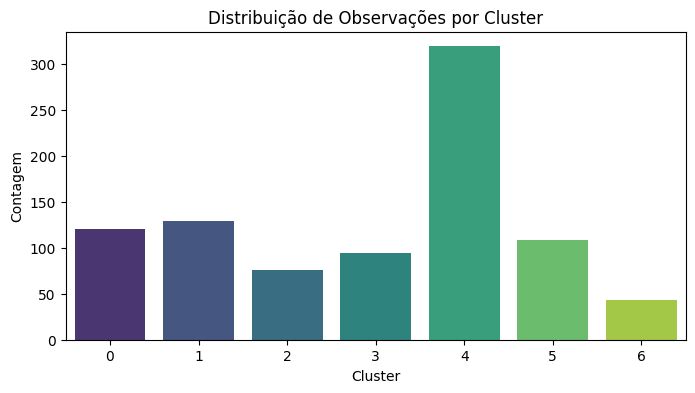


=== ESTATÍSTICAS DESCRITIVAS ===

cluster                0           1          2          3           4           5          6
Pclass count  120.000000  129.000000  76.000000  94.000000  319.000000  108.000000  43.000000
       mean     0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       std      0.000000    0.000000   0.000000   0.000000    0.000000    0.000000   0.000000
       min      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       25%      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       50%      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       75%      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       max      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
Age    count  120.000000  129.000000  76.000000  94.000000  319.000000  108.000000  43.000000
       mean     0.553542 

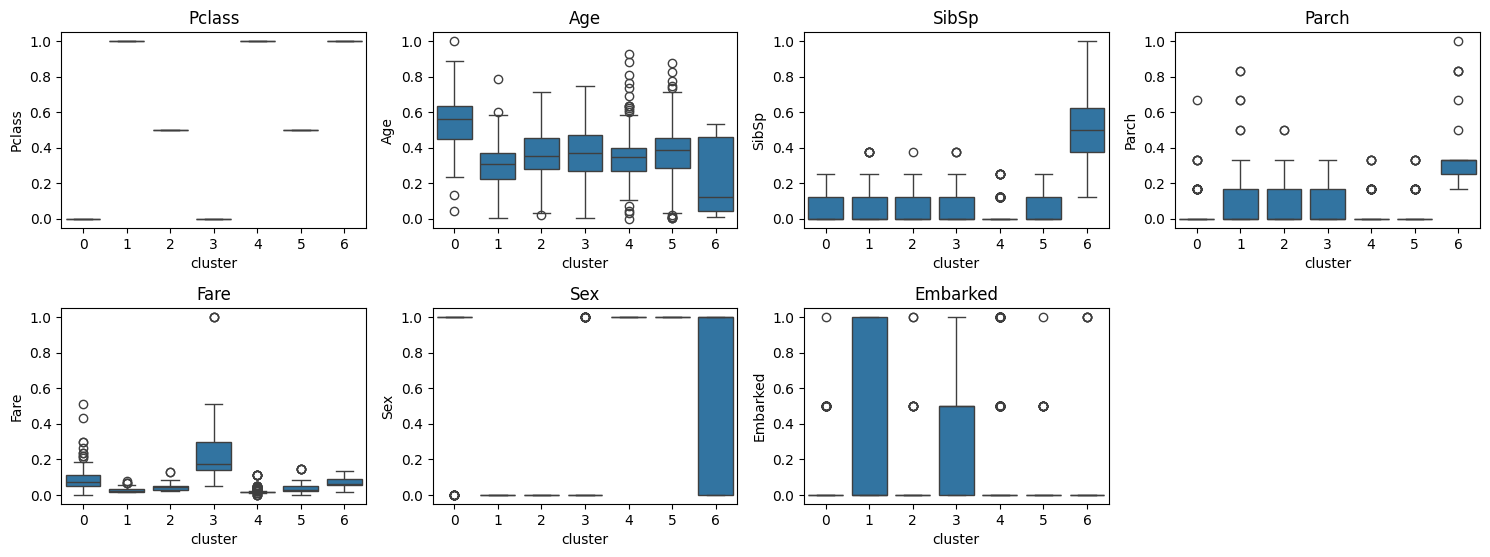


=== VARIÁVEIS COM MAIOR VARIAÇÃO ENTRE CLUSTERS ===

Embarked    0.273869
Sex         0.171615
Age         0.155137
Parch       0.124764
SibSp       0.103268
Fare        0.053163
Pclass      0.000000
dtype: float64

=== CONTAGEM POR CLUSTER ===

cluster
0    120
1    129
2     76
3     94
4    319
5    108
6     43
Name: count, dtype: int64


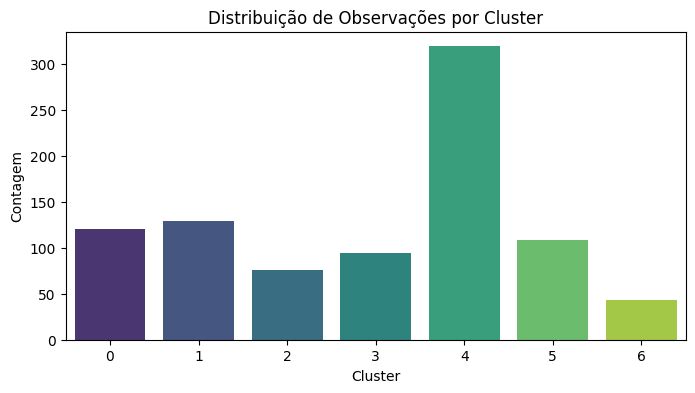


=== ESTATÍSTICAS DESCRITIVAS ===

cluster                0           1          2          3           4           5          6
Pclass count  120.000000  129.000000  76.000000  94.000000  319.000000  108.000000  43.000000
       mean     0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       std      0.000000    0.000000   0.000000   0.000000    0.000000    0.000000   0.000000
       min      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       25%      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       50%      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       75%      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       max      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
Age    count  120.000000  129.000000  76.000000  94.000000  319.000000  108.000000  43.000000
       mean     0.553542 

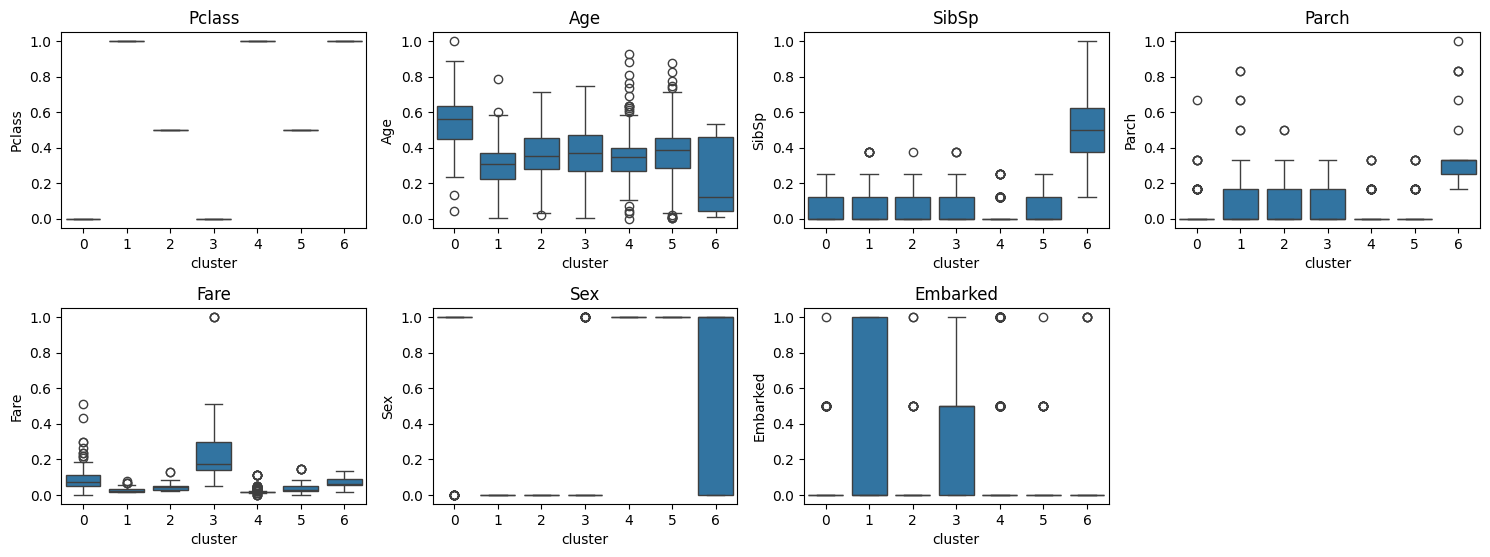


=== VARIÁVEIS COM MAIOR VARIAÇÃO ENTRE CLUSTERS ===

Embarked    0.273869
Sex         0.171615
Age         0.155137
Parch       0.124764
SibSp       0.103268
Fare        0.053163
Pclass      0.000000
dtype: float64

=== CONTAGEM POR CLUSTER ===

cluster
0    120
1    129
2     76
3     94
4    319
5    108
6     43
Name: count, dtype: int64


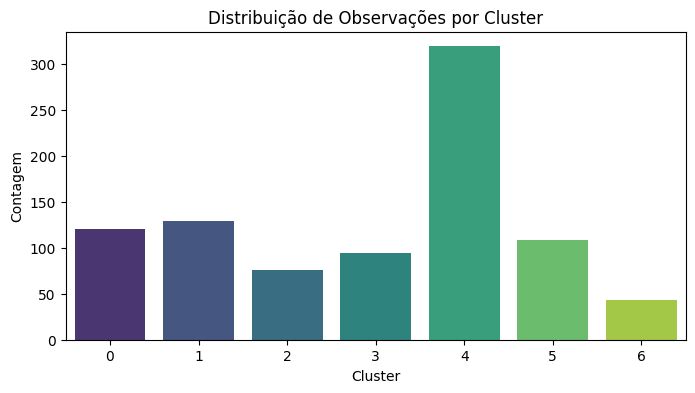


=== ESTATÍSTICAS DESCRITIVAS ===

cluster                0           1          2          3           4           5          6
Pclass count  120.000000  129.000000  76.000000  94.000000  319.000000  108.000000  43.000000
       mean     0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       std      0.000000    0.000000   0.000000   0.000000    0.000000    0.000000   0.000000
       min      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       25%      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       50%      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       75%      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
       max      0.000000    1.000000   0.500000   0.000000    1.000000    0.500000   1.000000
Age    count  120.000000  129.000000  76.000000  94.000000  319.000000  108.000000  43.000000
       mean     0.553542 

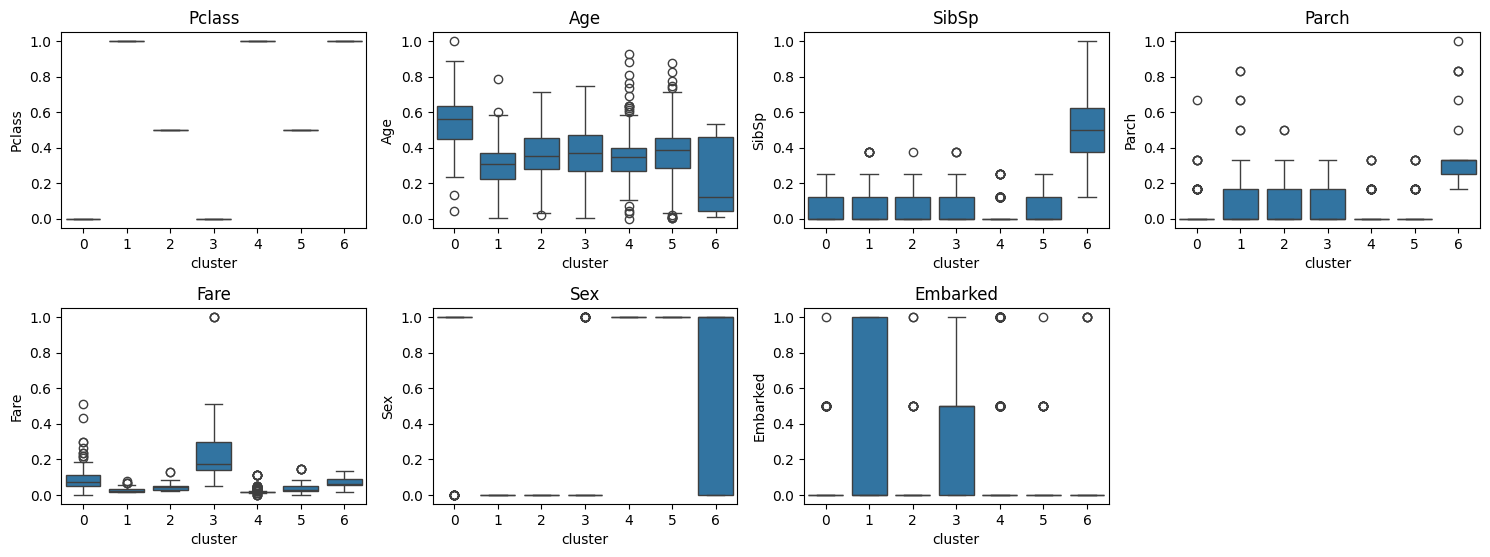


=== VARIÁVEIS COM MAIOR VARIAÇÃO ENTRE CLUSTERS ===

Embarked    0.273869
Sex         0.171615
Age         0.155137
Parch       0.124764
SibSp       0.103268
Fare        0.053163
Pclass      0.000000
dtype: float64
         Pclass       Age     SibSp     Parch      Fare       Sex  Embarked
cluster                                                                    
0           0.0  0.553542  0.043750  0.036111  0.099964  0.875000  0.120833
1           1.0  0.292768  0.064922  0.096899  0.026264  0.000000  0.344961
2           0.5  0.359450  0.060855  0.100877  0.042883  0.000000  0.072368
3           0.0  0.376581  0.063830  0.090426  0.246511  0.180851  0.319149
4           1.0  0.348201  0.022335  0.014107  0.020206  1.000000  0.177116
5           0.5  0.384585  0.042824  0.037037  0.038533  1.000000  0.055556
6           1.0  0.196655  0.517442  0.352713  0.076104  0.651163  0.093023
Embarked    0.273869
Sex         0.171615
Age         0.155137
Parch       0.124764
SibSp       0.10

In [1400]:
resultados = analisar_clusters(train_df_normalized, cluster_col='cluster')
# Análise básica
resultados = analisar_clusters(train_df_normalized)

# Personalizando
resultados = analisar_clusters(
    train_df_normalized,
    cluster_col='cluster',
    max_variaveis=8,
    salvar_plots=True
)

# Acessando resultados específicos depois
print(resultados['medias'])
print(resultados['variaveis_discriminantes'].head(5))